In [1]:
fnames = io.l1b_filenames('mvn_iuv_l1b_cruisecal2-mode080-muv_20140521T12002', iterator=False)

In [2]:
fname = fnames[0]
fnames # checking if there's more than one version of it in stage.

['/maven_iuvs/stage/products/level1b/mvn_iuv_l1b_cruisecal2-mode080-muv_20140521T120029_v01_r01.fits.gz']

In [13]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style("white")

In [4]:
l1b = io.L1BReader(fname)

In [10]:
%matplotlib inline

In [11]:
plt.ion()

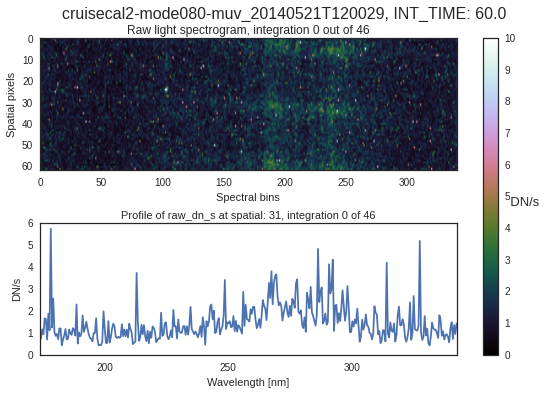

In [14]:
l1b.plot_raw_overview(0, save_token='1_int0', proflog=False, imglog=False);

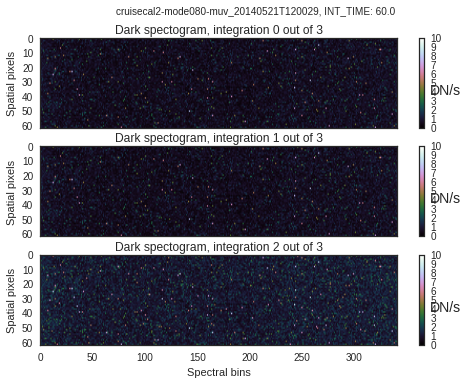

In [15]:
l1b.plot_dark_spectrograms()

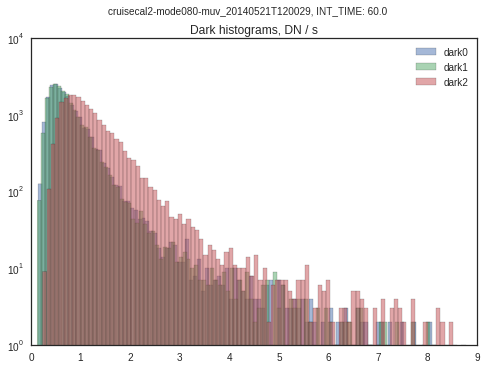

In [16]:
l1b.plot_dark_histograms(save=True)

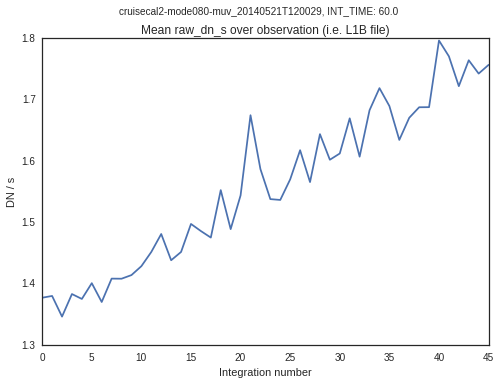

In [17]:
l1b.plot_mean_raw_values()

In [20]:
sns.set_palette('bright', 5)

In [19]:
import os
def plot_coeffs(results, ndark, token=''):
    results.index.name = 'Integrations'
    results.filter(regex='AddScaler').plot(title="Dark{} against all lights, {}".format(ndark,
                                                                                        token),
                                           ylim=[-0.5, 2])
    results['MultScaler'].plot(color=sns.color_palette()[1],
                                            ylim=[-0.5, 2],
                                            ls='--', legend=True)

    for col,ls in zip(results.filter(regex='poly1_'), ['-', '--']):
        results[col].plot(color=sns.color_palette()[2], legend=True, linestyle=ls)
    for col,ls in zip(results.filter(regex='poly2_'), ['-', '--','-.']):
        results[col].plot(color=sns.color_palette()[3], legend=True, linestyle=ls)
    savename = os.path.join(str(io.plotfolder),
                            'dark{}_vs_all_lights_'+token+'.png').format(ndark)
    plt.savefig(savename, dpi=150)    

from iuvs.multitools import *
def fit_over_integrations(endslice=None, spa_slice=None, spe_slice=None):
    all_coeffs = []
    all_residual_std = []
    # endslice just to make faster single executions possible
    for ndark in range(l1b.n_darks)[:endslice]:
        print('doing dark {}'.format(ndark))
        coeffs = []
        residual_mean = []
        residual_std = []
        current_residual_mean = []
        current_residual_std = []
        prog = IntProgress(min=0, max=l1b.n_integrations)
        display(prog)
        for nraw in range(l1b.n_integrations):
            fitter = scaling.DarkFitter(l1b, nraw, ndark, 
                                        spa_slice=spa_slice, spe_slice=spe_slice)
            coeffs.append(fitter.p_dicts)
            residual_mean.append(fitter.residual_mean)
            residual_std.append(fitter.residual_std)
            current_residual_mean.append(fitter.currentresidual.mean())
            current_residual_std.append(fitter.currentresidual.std())
            prog.value = nraw
        all_coeffs.append(pd.DataFrame(coeffs))
#         residual_mean = pd.DataFrame(residual_mean)
        residual_std = pd.DataFrame(residual_std)
#         residual_mean['current'] = current_residual_mean
        residual_std['current'] = current_residual_std
        all_residual_std.append(residual_std)
    return all_coeffs, all_residual_std

# Automatic scaling window

In [29]:
plt.close('all')

In [14]:
coeffs, res_std = fit_over_integrations()

doing dark 0
doing dark 1
doing dark 2


<IPython.core.display.Javascript object>


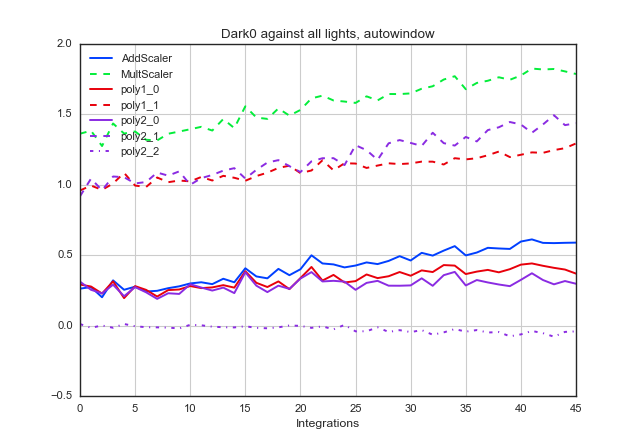

<IPython.core.display.Javascript object>


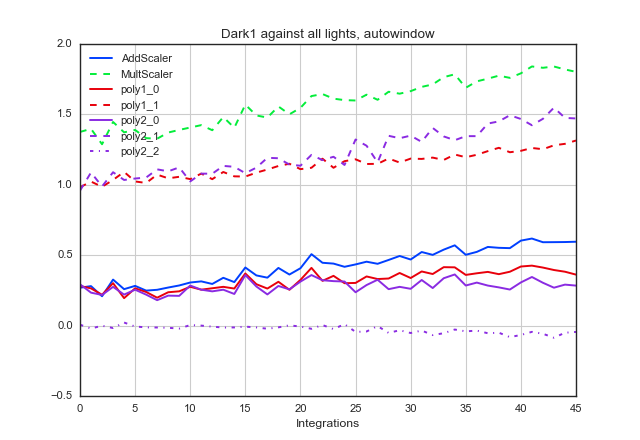

<IPython.core.display.Javascript object>


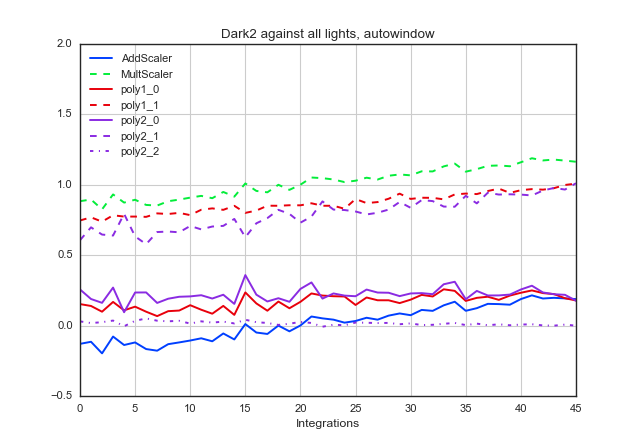

In [15]:
for j in range(3):
    plot_coeffs(coeffs[j], j, token='autowindow')

<IPython.core.display.Javascript object>


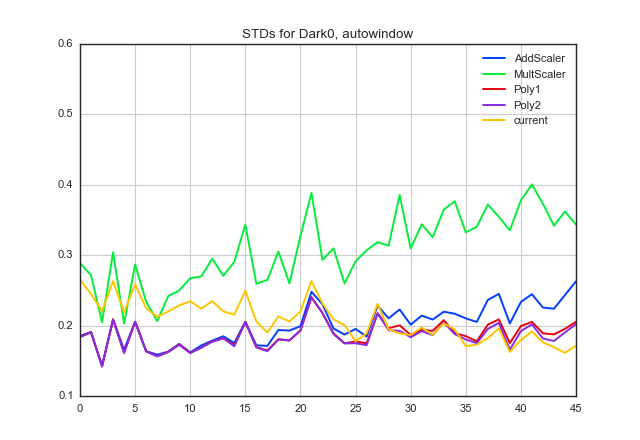

<IPython.core.display.Javascript object>


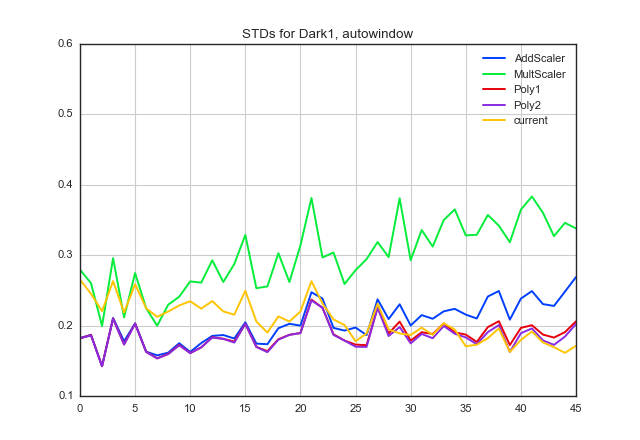

<IPython.core.display.Javascript object>


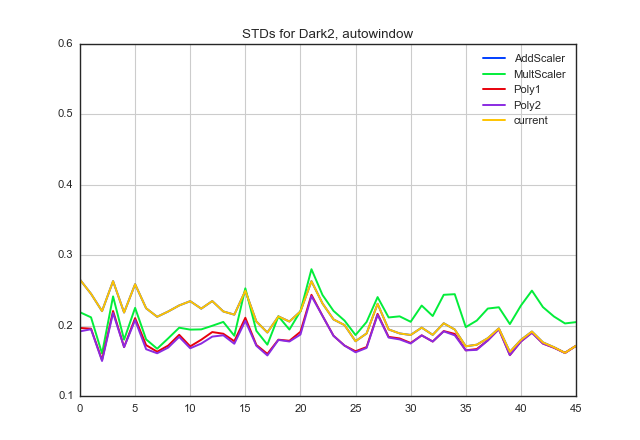

In [16]:
for j in range(3):
    res_std[j].plot(title='STDs for Dark{}, autowindow'.format(j), ylim=(0.1, 0.6))
    plt.savefig('/Users/klay6683/plots/STDs_dark{}_autowindow.png'.format(j), dpi=150)

# Fixed scaling window

In [17]:
spa_slice, spe_slice = l1b.find_scaling_window(l1b.raw_dn_s[0])

In [18]:
coeffs, res_std = fit_over_integrations(spa_slice=spa_slice, spe_slice=spe_slice)

doing dark 0
doing dark 1
doing dark 2


<IPython.core.display.Javascript object>


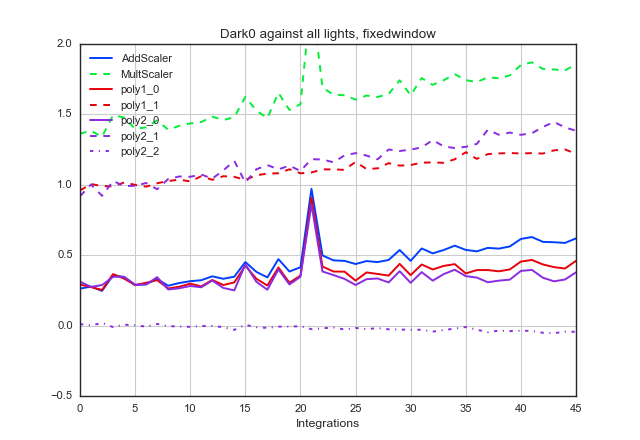

<IPython.core.display.Javascript object>


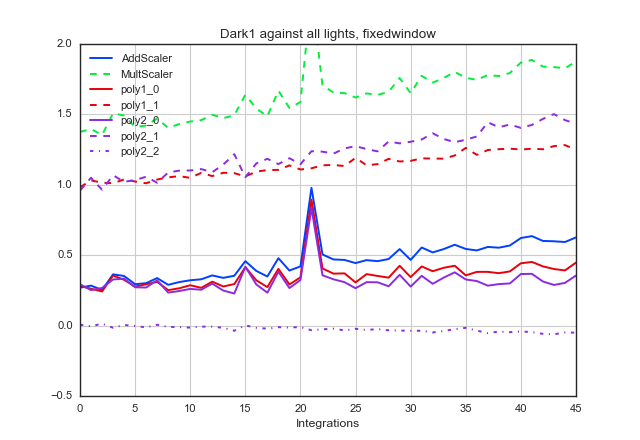

<IPython.core.display.Javascript object>


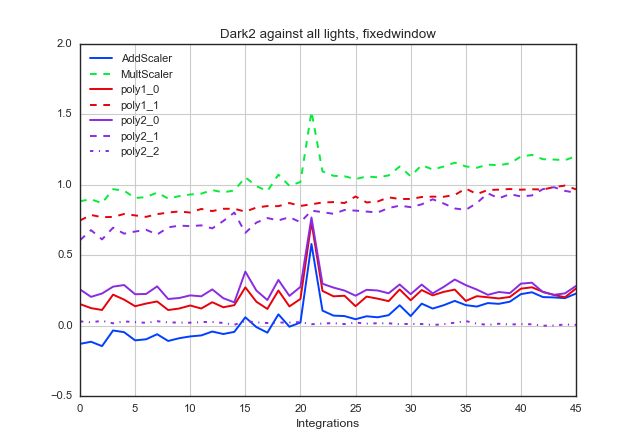

In [19]:
for j in range(3):
    plot_coeffs(coeffs[j], j, token='fixedwindow')

<IPython.core.display.Javascript object>


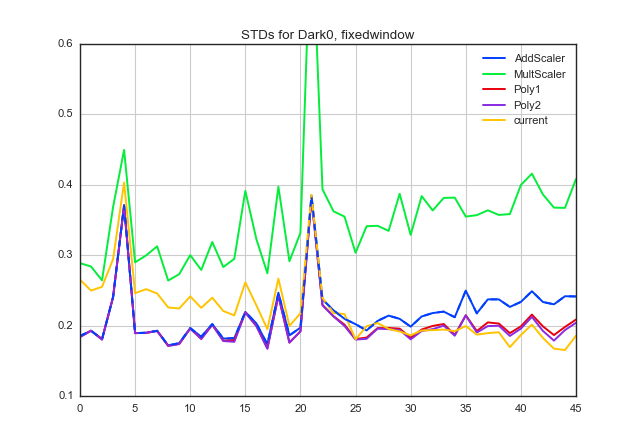

<IPython.core.display.Javascript object>


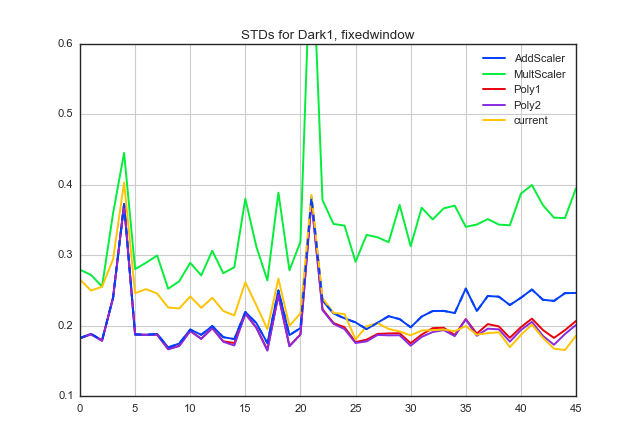

<IPython.core.display.Javascript object>


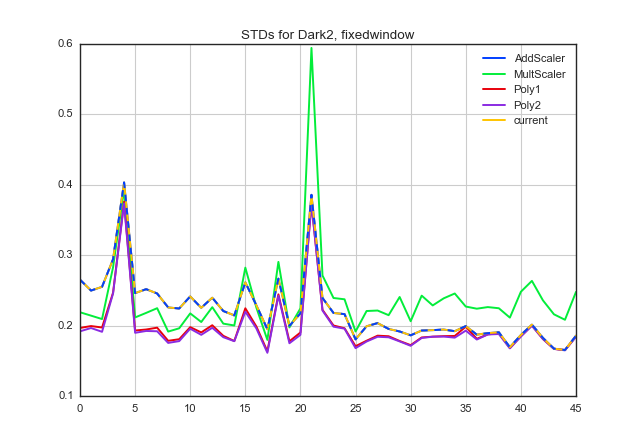

In [20]:
for j in range(3):
    res_std[j].plot(title='STDs for Dark{}, fixedwindow'.format(j), ylim=(0.1, 0.6))
    res_std[j]['AddScaler'].plot(style='--')
    plt.savefig('/Users/klay6683/plots/STDs_dark{}_fixedwindow.png'.format(j), dpi=150)

# Applying poly1 and compare with current subtraction

In [ ]:
# %load http://matplotlib.org/1.4.2/examples/animation/basic_example_writer.py
# Same as basic_example, but writes files using a single MovieWriter instance
# without putting on screen
# -*- noplot -*-
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def update_line(num, data, line):
    line.set_data(data[...,:num])
    return line,

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)


fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
    interval=50, blit=True)
line_ani.save('lines.mp4', writer=writer)

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
    blit=True)
im_ani.save('im.mp4', writer=writer)


In [29]:
def apply_and_compare(l1b, Scaler=scaling.PolyScaler1):
    plt.ioff()
    plt.rcParams['image.cmap']='cubehelix'
    plt.rcParams['image.interpolation'] = None
    
    # determine visual max and min for image plots
    min_, max_ = np.percentile(l1b.dds_dn_s, (1,99))
    for ndark in range(l1b.n_darks):
        prog = IntProgress(min=0, max=l1b.n_integrations)
        display(prog)
        fulldark = l1b.get_integration('dark_dn_s', ndark)
        for nraw in range(l1b.n_integrations):
            fullraw = l1b.get_integration('raw_dn_s', nraw)
            spa_slice, spe_slice = l1b.find_scaling_window(fullraw)
            raw_subframe = fullraw[spa_slice, spe_slice]
            dark_subframe = fulldark[spa_slice, spe_slice]
            scaler = Scaler(dark_subframe, raw_subframe)
            scaler.do_fit()
            newdark = scaler.apply_fit(fulldark)
            subtracted = fullraw - newdark
            current = l1b.get_integration('dds_dn_s', nraw)

            
#             # plotting
#             fig, ax = plt.subplots(nrows=3)
#             rawmin, rawmax = np.percentile(fullraw, (1,99))
#             ax[0].imshow(fullraw, vmin=rawmin, vmax=rawmax)
#             ax[0].set_title('Raw, {}_{} (NOT same colormap!)'.format(ndark, nraw))
#             ax[1].imshow(current, vmin=min_, vmax=max_)
#             ax[1].set_title('Current dark subtraction')
#             im = ax[2].imshow(subtracted, vmin=min_, vmax=max_)
#             ax[2].set_title("{} scaled dark subtracted".format(Scaler))
#             ax[2].set_xlabel('Spectral pixel number')
#             fig.tight_layout()
#             fig.subplots_adjust(top=0.9, bottom=0.1)
#             cb = plt.colorbar(im, ax=ax.ravel().tolist())
#             cb.set_label('  DN/s', fontsize=13, rotation=0)
#             fig.savefig(os.path.join(str(io.plotfolder),
#                                      'compare_{}_{}.png'.format(ndark, str(nraw).zfill(2))),
#                         dpi=120)
#             plt.close(fig)
            with sns.axes_style('whitegrid'):
                fig, ax = plt.subplots(nrows=3, sharex=True)
                for row, myaxis in zip([5,31,55], ax):
                    for data, style,name in zip([fullraw, current, subtracted],
                                                ['b-','r-','g-'],
                                                ['Raw', 'Current', 'ScaledDark']):
                        myaxis.plot(data[row], style, label='{}, row{}'.format(name, row),
                                    lw=1, alpha=0.7)
                    myaxis.set_ylim(-0.5, 4)
                    myaxis.legend()
                    myaxis.set_ylabel('DN / s')
                    myaxis.set_title('Row {}'.format(row), fontsize=10)
                ax[2].set_xlabel('Spectral pixel number')
                fig.suptitle('Profile comparison, dark{}'.format(ndark))
                fig.savefig(os.path.join(str(io.plotfolder),
                                         'mean_profs_compare_{}_{}.png'.format(ndark, str(nraw).zfill(2))),
                           dpi=120)
                plt.close(fig)
            prog.value = nraw+1

In [ ]:
apply_and_compare(l1b)